In [1663]:
import numpy as np
import random
import pandas as pd
import geopandas as gpd

import requests

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from shapely.geometry import Point
from IPython.display import HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.options.mode.copy_on_write = True

### pcdf from disc

In [1349]:
# pcdf = pd.read_csv('pcdf.csv')
# 
# pcdf = pcdf[[
#     'Postcode',
#     'Latitude',
#     'Longitude',
#     'pcd2',
#     'pcd_sect',
#     'pcd_dist',
#     'pcd_area',
#     'Postcode Area',
#     #'Post code Area Code',
#     #'Postcode Districts',
#     #'Post code Sectors',
#     #'Live ',
#     #'Terminated ',
#     #'Total'
# ]]

In [1350]:
#pcdf.head()#['Postcode'][0]
#.str.contains('  ', regex = False)

### Latitude Altitude

In [1352]:
# Office for National Statistics

# ONS Postcode Directory (August 2024) for the UK 
# Obtained from: https://ons.maps.arcgis.com/home/search.html?restrict=true&sortField=relevance&sortOrder=desc&searchTerm=tags%3AONS+Postcode+Directory#content)

ukpostcodes = pd.read_csv('dataset/ONSPD_AUG_2024_UK.csv', usecols = ['pcd2', 'lat', 'long'])

In [1353]:
ukpostcodes['pcd2'] = ukpostcodes['pcd2'].str.replace('\s{2,}', ' ', regex = True)

ukpostcodes['pcd2'][0]

ukpostcodes.rename({
    'pcd2':'Postcode', 
    "lat": "Latitude", 
    "long":"Longitude"}, axis = 1, inplace = True)

In [1354]:
ukpostcodes.head()

,Postcode,Latitude,Longitude
0,AB1 0AA,57.101474,-2.242851
1,AB1 0AB,57.102554,-2.246308
2,AB1 0AD,57.100556,-2.248342
3,AB1 0AE,57.084444,-2.255708
4,AB1 0AF,57.096656,-2.258102


### Postcode, Sector, Area

In [1356]:
# Postcode ~ Postcode Sector ~ Postcode District to Postcode Area (August 2022) to Output Area (2021) Lookup in EW
# https://geoportal.statistics.gov.uk/datasets/ons::postcode-to-postcode-sector-to-postcode-district-to-postcode-area-august-2022-to-output-area-2021-lookup-in-ew/about

postcode_areas = pd.read_csv('dataset/pcd_pcds_pcdd_pcda_oa21_aug_22__ew_lu.csv', usecols = ['pcd2', 'pcd_dist', 'pcd_area', 'pcd_sect'])

In [1357]:
postcode_areas.head()

,pcd2,pcd_sect,pcd_dist,pcd_area
0,AL1 1AA,AL1 1,AL1,AL
1,AL1 1AB,AL1 1,AL1,AL
2,AL1 1AD,AL1 1,AL1,AL
3,AL1 1AE,AL1 1,AL1,AL
4,AL1 1AF,AL1 1,AL1,AL


In [1358]:
#Two space to one space
postcode_areas['pcd_area'] = postcode_areas['pcd_area'].str.split('\d', expand=True)[0]
postcode_areas['pcd2'] = postcode_areas['pcd2'].str.replace('\s{2,}', ' ', regex = True)

In [1359]:
# Sector was split wrong where the sector number has double digits

postcode_areas[postcode_areas['pcd_dist'] == 'AL10'].head()

,pcd2,pcd_sect,pcd_dist,pcd_area
2017,AL10 0AA,AL100,AL10,AL
2018,AL10 0AB,AL100,AL10,AL
2019,AL10 0AD,AL100,AL10,AL
2020,AL10 0AE,AL100,AL10,AL
2021,AL10 0AF,AL100,AL10,AL


In [1360]:
def extract_sect(pcd):
    if len(pcd) >= 4 and pcd[3] == ' ':
        return pcd[:5]  # Get the first 5 characters (e.g., "AL1 1")
    elif len(pcd) >= 5 and pcd[4] == ' ':
        return pcd[:6]  # Get the first 6 characters (e.g., "AL10 0")
    else:
        return None  # Return None if it doesn't match the expected format

In [1361]:
#Fixing sector
postcode_areas['pcd_sect'] = postcode_areas['pcd2'].apply(extract_sect)

In [1362]:
postcode_areas[postcode_areas['pcd_dist'] == 'AL10'].head()

,pcd2,pcd_sect,pcd_dist,pcd_area
2017,AL10 0AA,AL10 0,AL10,AL
2018,AL10 0AB,AL10 0,AL10,AL
2019,AL10 0AD,AL10 0,AL10,AL
2020,AL10 0AE,AL10 0,AL10,AL
2021,AL10 0AF,AL10 0,AL10,AL


### Postcode Area Names

In [1364]:
postcode_area_names = pd.read_csv('dataset/Postcode Area Names (ONSPD User Guide Aug 2024).csv')#, usecols = ['Postcode Area', 'Postcode Area Name', 'Region','Status'])

In [1620]:
postcode_area_names.head()

,Postcode Area,Post code Area Code,Postcode Districts,Post code Sectors,Live,Terminated,Total
0,Aberdeen,AB,40,180,"17,372","21,869","39,241"
1,St Albans,AL,10,39,"7,791","3,678","11,469"
2,Birmingham,B,79,268,"41,907","20,621","62,528"
3,Bath,BA,19,81,"15,490","5,017","20,507"
4,Blackburn,BB,15,79,"13,532","5,741","19,273"


In [1366]:
postcode_area_names.rename(columns = {'Postcode Area ':'Postcode Area'},inplace = True)

In [1367]:
postcode_area_names['Post code Area Code'] = postcode_area_names['Post code Area Code'].str.strip(' ') #.str.contains(' ').sum()  All rows have space after the area code

### ~ pcdf

In [1369]:
pcdf = ukpostcodes.merge(
    postcode_areas.merge(postcode_area_names, how = 'left', left_on ='pcd_area', right_on = 'Post code Area Code'),
    how = 'left', left_on ='Postcode', right_on = 'pcd2')

#### It's ok to have NAs !!

In [1371]:
pcdf.head(2)

,Postcode,Latitude,Longitude,pcd2,pcd_sect,pcd_dist,pcd_area,Postcode Area,Post code Area Code,Postcode Districts,Post code Sectors,Live,Terminated,Total
0,AB1 0AA,57.101474,-2.242851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AB1 0AB,57.102554,-2.246308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1372]:
pcdf = pcdf[['Postcode',
 'Latitude',
 'Longitude',
 'pcd2',
 'pcd_sect',
 'pcd_dist',
 'pcd_area',
 'Postcode Area']]

In [1373]:
pcdf[pcdf['pcd_dist'] == 'AL10'].head(2)

,Postcode,Latitude,Longitude,pcd2,pcd_sect,pcd_dist,pcd_area,Postcode Area
41264,AL10 0AA,51.764264,-0.226254,AL10 0AA,AL10 0,AL10,AL,St Albans
41265,AL10 0AB,51.773137,-0.223316,AL10 0AB,AL10 0,AL10,AL,St Albans


### Population

In [1375]:
# https://www.nomisweb.co.uk/sources/census_2021_pc

population = pd.read_csv('dataset/Postcode_Estimates_Table_2021.csv', usecols = ['Postcode', 'Count']).groupby('Postcode', as_index = False).sum()

In [1376]:
population.head()

,Postcode,Count
0,AL1 1AG,13
1,AL1 1AJ,129
2,AL1 1AR,28
3,AL1 1AS,31
4,AL1 1AT,20


In [1377]:
#Checking if the dataset matches the population of England and Wales for 2021
#population['Count'].sum()
#UKpop2021 =  59642000 #England and Wales
#error = (UKpop2021 - population['Count'].sum())/UKpop2021*100
#error # 0.07 %

In [1378]:
# I don't want any postcodes to reappear in the dataset so I will group them and sum the Count column

population = population.groupby('Postcode', as_index = False).sum()

In [1379]:
population.head()

,Postcode,Count
0,AL1 1AG,13
1,AL1 1AJ,129
2,AL1 1AR,28
3,AL1 1AS,31
4,AL1 1AT,20


In [1380]:
population = population.merge(p_merged[['Postcode',
                       'Latitude',
                       'Longitude',
                       #'pcd2',
                       'pcd_sect',
                       'pcd_dist',
                       'pcd_area',
                       'Postcode Area',
                       #'Post code Area Code',
                       #'Postcode Districts',
                       #'Post code Sectors',
                       #'Live ',
                       #'Terminated ',
                       #'Total'
                      ]],
                how = 'left',
                left_on = 'Postcode',
                right_on = 'Postcode')

In [1381]:
population.groupby('pcd_dist', as_index = False).sum('Count')

,pcd_dist,Count,Latitude,Longitude
0,AL1,39039,51127.846275,-320.991997
1,AL10,38956,34886.152616,-156.803818
2,AL2,24207,34444.800523,-224.254201
3,AL3,29625,45360.262279,-332.417518
4,AL4,28431,37847.286609,-215.879287
...,...,...,...,...
2296,YO60,4579,13359.300799,-231.939871
2297,YO61,14682,34039.795699,-752.212404
2298,YO62,12065,31842.381608,-583.774556
2299,YO7,21337,46145.016299,-1149.996565


### ~ popdf

In [1383]:
popdf = population.merge(
    population.groupby('pcd_area', as_index = False).sum('Count')[['pcd_area', 'Count']],
    how = 'left',
    left_on = 'pcd_area',
    right_on = 'pcd_area',
    suffixes = ('', '_area')
).merge(
    population.groupby('pcd_dist', as_index = False).sum('Count')[['pcd_dist', 'Count']],
    how = 'left',
    left_on = 'pcd_dist',
    right_on = 'pcd_dist',
    suffixes = ('', '_dist')
).merge(
    population.groupby('pcd_sect', as_index = False).sum('Count')[['pcd_sect', 'Count']],
    how = 'left',
    left_on = 'pcd_sect',
    right_on = 'pcd_sect',
    suffixes = ('', '_sect'))#.iloc[[40,1662,990,2328,385477, 646946]]


In [1384]:
popdf.rename(
    columns = {
        'Count_area' : 'pop_area',
        'Count_dist' : 'pop_dist',
        'Count_sect' : 'pop_sect'
    },
    inplace = True
)

In [1385]:
popdf.head()

,Postcode,Count,Latitude,Longitude,pcd_sect,pcd_dist,pcd_area,Postcode Area,pop_area,pop_dist,pop_sect
0,AL1 1AG,13,51.745290,-0.328628,AL1 1,AL1,AL,St Albans,266524.0,39039.0,6075.0
1,AL1 1AJ,129,51.744498,-0.328599,AL1 1,AL1,AL,St Albans,266524.0,39039.0,6075.0
2,AL1 1AR,28,51.739727,-0.317492,AL1 1,AL1,AL,St Albans,266524.0,39039.0,6075.0
3,AL1 1AS,31,51.749073,-0.335471,AL1 1,AL1,AL,St Albans,266524.0,39039.0,6075.0
4,AL1 1AT,20,51.742011,-0.319421,AL1 1,AL1,AL,St Albans,266524.0,39039.0,6075.0


### 2024

In [1387]:
# tickets_2024 = pd.read_csv('df.csv')

In [1388]:
# season_tickets_2024 = tickets_2024[tickets_2024['Ticket Type'] == 'Season'][[
#     #'id',
#     #'order_item_id',
#     #'Ticket',
#     'Type',
#     'Price',
#     #'Coupon',
#     #'Qty',
#     #'Total Revenue',
#     #'Ticket Type',
#     #'Outcode',
#     #'Incode',
#     'Postcode',
#     'Latitude',
#     'Longitude',
#     'pcd_sect',
#     'pcd_dist',
#     'pcd_area',
#     'Postcode Area',
#     'pop_area',
#     'pop_dist',
#     'pop_sect']]#

In [1389]:
season_tickets_2024 = pd.read_excel('dataset/season_tickets.xlsx')

In [1390]:
season_tickets_2024 = season_tickets_2024[[
    'id',
    'order_item_id',
    #'Ticket',
    #'Channel',
    'Type',
    'Price',
    #'Coupon',
    'Qty',
    'Postcode',
    'Column1']
]

In [1391]:
season_tickets_2024.rename(columns = {'Price':'Ticket Price Paid',
                                      'Type':'Ticket Type',
                                      'Postcode':'Outcode',
                                      'Column1':'Incode'}, inplace = True)

In [1392]:
season_tickets_2024['Ticket Type'] = season_tickets_2024['Ticket Type'].str.replace('Hospitality', 'Boardroom')

In [1393]:
#season_tickets_2024['Postcode']
season_tickets_2024['Postcode'] = season_tickets_2024['Outcode'].astype(str) + " " + season_tickets_2024['Incode'].astype(str)

In [1394]:
season_tickets_2024.head()

,id,order_item_id,Ticket Type,Ticket Price Paid,Qty,Outcode,Incode,Postcode
0,78016,74365,Adult,0.0,1,AL3,4SZ,AL3 4SZ
1,78018,74368,Next Gen 18-23,75.0,1,AL3,4GJ,AL3 4GJ
2,78033,74386,Adult,250.0,1,AL4,9PE,AL4 9PE
3,78035,74388,Concession,200.0,1,AL1,4PW,AL1 4PW
4,78035,74389,Concession,0.0,1,AL1,4PW,AL1 4PW


### 2025

In [1396]:
season_tickets_2025 = pd.read_csv('dataset/season-ticket-2425.csv')

In [1397]:
season_tickets_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TicketID              347 non-null    object 
 1   TicketID Numeric      347 non-null    int64  
 2   OrderID               347 non-null    int64  
 3   Variation             347 non-null    object 
 4   Attendee Telephone    0 non-null      float64
 5   Attendee Company      58 non-null     object 
 6   Attendee Designation  48 non-null     object 
 7   Order Status          347 non-null    object 
 8   Payment Method        347 non-null    object 
 9   Order Date            347 non-null    object 
 10  Ticket Price          344 non-null    float64
 11  Ticket Price Paid     344 non-null    float64
 12  Billing City          274 non-null    object 
 13  Billing Postal Code   274 non-null    object 
 14  Billing Country       275 non-null    object 
 15  Billing State         1

In [1398]:
# No duplicates in:

# season_tickets_2025['TicketID'].duplicated().sum()
# season_tickets_2025['TicketID Numeric'].duplicated().sum()

In [1399]:
# All postcodes do not contain space

# season_tickets_2025[season_tickets_2025['Billing Postal Code'].str.contains(' ', na=True) == False]

In [1400]:
# All Billing Country = either GB or NaN

# season_tickets_2025[season_tickets_2025['Billing Country'] != 'GB']['Billing Country'].notna().sum()
# season_tickets_2025['Billing Country'].unique()

In [1401]:
season_tickets_2025['Ticket Price'] = season_tickets_2025['Ticket Price'].round(2)
season_tickets_2025['Ticket Price Paid'] = season_tickets_2025['Ticket Price Paid'].round(2)
#season_tickets_2025.head(2)

In [1402]:
# All Variation variables contain 'Ticket Type: ', column and column name will be amendamended 
# season_tickets_2025[season_tickets_2025['Variation'].str.contains('Ticket Type: ') == False]

season_tickets_2025['Variation'] = season_tickets_2025['Variation'].str.replace('Ticket Type: ', '', regex=False)
season_tickets_2025.rename(columns = {'Variation':'Ticket Type'},  inplace = True)
#season_tickets_2025.head(2)

In [1403]:
season_tickets_2025['Ticket Type'] = season_tickets_2025['Ticket Type'].str.replace('Next Gen 18 23', 'Next Gen 18-23', regex=False)

season_tickets_2025['Ticket Type'].unique()

array(['Under 18', 'Boardroom', 'Next Gen 18-23', 'Adult', 'Carer',
       'Concession', 'Under 12'], dtype=object)

In [1404]:
# All Attendee Telephone is NULL, column removed

# season_tickets_2025[season_tickets_2025['Attendee Telephone'].notna()]

remove_col = season_tickets_2025.columns.tolist().index('Attendee Telephone') # nth column
all_cols = list(range(0,len(season_tickets_2025.columns))) # index
all_cols.remove(remove_col)

season_tickets_2025 = season_tickets_2025.iloc[:, list(all_cols)]

#df1.head(2)

### Total Revenue

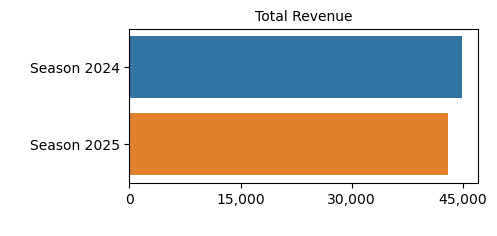

In [1406]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(4.5, 2))

sns.barplot(x = 'Total Revenue', 
            y = 'Ticket Type',
            data = pd.DataFrame({'Ticket Type': ['Season 2024', 'Season 2025'],
             'Total Revenue': [season_tickets_2024['Ticket Price Paid'].sum(), df1['Ticket Price Paid'].sum()]})
           )

plt.title('Total Revenue',fontsize=10)
plt.xticks(np.arange(0, 50001, step=15000))
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));
plt.xlabel(' ')
plt.ylabel(' ')

plt.show()

### Total Revenue by Type

In [1408]:
grouped_season_tickets_2024 = season_tickets_2024[['Ticket Type', 'Ticket Price Paid']].groupby('Ticket Type', as_index = False).sum('Ticket Price Paid').sort_values('Ticket Price Paid', ascending=False)

grouped_season_tickets_2024['Year'] = pd.DataFrame({'Year': ['2024', '2024', '2024', '2024', '2024', '2024', '2024']})

#grouped_season_tickets_2024

In [1409]:
grouped_season_tickets_2025 = season_tickets_2025[['Ticket Type', 'Ticket Price Paid']].groupby('Ticket Type', as_index = False).sum('Ticket Price Paid').sort_values('Ticket Price Paid', ascending=False)

grouped_season_tickets_2025['Year'] = pd.DataFrame({'Year': ['2025', '2025', '2025', '2025', '2025', '2025', '2025']})

In [1410]:
grouped_season_tickets_concat = pd.concat([grouped_season_tickets_2025, grouped_season_tickets_2024], axis  =  0)
#grouped_season_tickets_concat

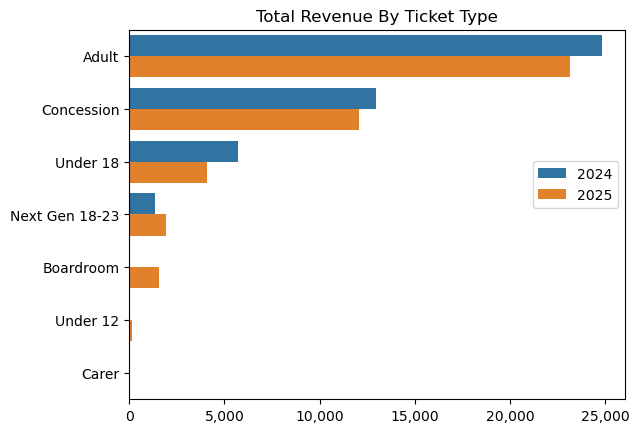

In [1411]:
ax = sns.barplot(
    data=grouped_season_tickets_concat,
    y='Ticket Type',
    x='Ticket Price Paid',
    hue='Year',  # Group bars by year
    hue_order=['2024', '2025']  # Ensure the legend and bar order
)

ax.set_title('Total Revenue By Ticket Type')
ax.set_xlabel('')
ax.set_ylabel('')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend(
    #title='Year', 
    loc='lower right', bbox_to_anchor=(1, 0.5))

plt.show()

### xxx

In [ ]:
# season_2024_pcdf

In [1414]:
season_2024_pcdf = season_tickets_2024[[
    'id',
    'order_item_id',
    'Ticket Type',
    'Ticket Price Paid',
    'Qty',
    #'Outcode',
    #'Incode',
    'Postcode'
]].merge(
    pcdf,
    how = 'left',
    on = 'Postcode'
).merge(
    popdf[[
        'Postcode',
        #'Count',
        #'Latitude',
        #'Longitude',
        #'pcd_sect',
        #'pcd_dist',
        #'pcd_area',
        #'Postcode Area',
        'pop_area',
        'pop_dist',
        'pop_sect']],
    how = 'left',
    on = 'Postcode'
)

In [1415]:
season_2025_pcdf = season_tickets_2025[[
    'TicketID',
    'TicketID Numeric',
    'OrderID',
    'Ticket Type',
    'Attendee Company',
    'Attendee Designation',
    'Order Status',
    'Payment Method',
    'Order Date',
    'Ticket Price',
    'Ticket Price Paid',
    'Billing City',
    'Billing Postal Code',
    'Billing Country',
    'Billing State'
]].merge(
    pcdf,
    how = 'left',
    left_on = 'Billing Postal Code',
    right_on = 'Postcode'
).merge(
    popdf[[
        'Postcode',
        #'Count',
        #'Latitude',
        #'Longitude',
        #'pcd_sect',
        #'pcd_dist',
        #'pcd_area',
        #'Postcode Area',
        'pop_area',
        'pop_dist',
        'pop_sect']],
    how = 'left',
    on = 'Postcode'
)

In [1416]:
season_2025_pcdf[season_2025_pcdf['Ticket Price Paid'] / season_2025_pcdf['Ticket Price'] < 1 ]

#season_2025_pcdf[season_2025_pcdf['Ticket Price Paid'] / season_2025_pcdf['Ticket Price'] < 1 ]['Attendee Designation'].unique()

#season_2025_pcdf[season_2025_pcdf['Ticket Price Paid'] / season_2025_pcdf['Ticket Price'] == 1 ]#['Attendee Designation'].unique()

,TicketID,TicketID Numeric,OrderID,Ticket Type,Attendee Company,Attendee Designation,Order Status,Payment Method,Order Date,Ticket Price,Ticket Price Paid,Billing City,Billing Postal Code,Billing Country,Billing State,Postcode,Latitude,Longitude,pcd2,pcd_sect,pcd_dist,pcd_area,Postcode Area,pop_area,pop_dist,pop_sect
2,#154366872387,427,154361,Boardroom,Conker Nation,Sponsor,Completed,fooeventspos-other,2024-10-05T12:06:50+01:00,595.0,99.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#154363394450,424,154361,Boardroom,Conker Nation,Sponsor,Completed,fooeventspos-other,2024-10-05T12:06:50+01:00,595.0,99.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#154364657984,425,154361,Boardroom,Conker Nation,Sponsor,Completed,fooeventspos-other,2024-10-05T12:06:50+01:00,595.0,99.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,#154365300529,426,154361,Boardroom,Conker Nation,Sponsor,Completed,fooeventspos-other,2024-10-05T12:06:50+01:00,595.0,99.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,#151527778007,421,151525,Adult,NaN,NaN,Completed,fooeventspos-square-terminal,2024-08-29T12:22:42+01:00,285.0,47.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,#142124860792,291,142121,Adult,NaN,NaN,Completed,fooeventspos-check-payment,2024-06-20T20:32:12+01:00,285.0,47.50,st albans,AL4 9PH,GB,Herts,AL4 9PH,51.768483,-0.305612,AL4 9PH,AL4 9,AL4,AL,St Albans,266524.0,28431.0,11410.0
132,#142123160735,290,142121,Adult,NaN,NaN,Completed,fooeventspos-check-payment,2024-06-20T20:32:12+01:00,285.0,47.50,st albans,AL4 9PH,GB,Herts,AL4 9PH,51.768483,-0.305612,AL4 9PH,AL4 9,AL4,AL,St Albans,266524.0,28431.0,11410.0
137,#141519607529,285,141516,Under 18,NaN,NaN,Completed,fooeventspos-square-manual,2024-06-03T17:22:47+01:00,55.0,9.17,St Albans,AL1 4NS,GB,UK,AL1 4NS,51.757776,-0.322690,AL1 4NS,AL1 4,AL1,AL,St Albans,266524.0,39039.0,9627.0
138,#141518514390,284,141516,Adult,NaN,NaN,Completed,fooeventspos-square-manual,2024-06-03T17:22:47+01:00,285.0,47.50,St Albans,AL1 4NS,GB,UK,AL1 4NS,51.757776,-0.322690,AL1 4NS,AL1 4,AL1,AL,St Albans,266524.0,39039.0,9627.0


In [1417]:
# Ticket Price Paid > Ticket Price

# season_tickets_2025[season_tickets_2025['Ticket Price Paid'] > season_tickets_2025['Ticket Price Paid']]

# No Qty, it will be considered as Qty = 1

In [1418]:
# season_tickets_2025[season_tickets_2025['TicketID'].duplicated()]

### Grouped Data

### Area

In [1757]:
season_2024_area = season_2024.groupby(['pcd_area', 
                                        #'Ticket Type'
                                       ], as_index=False).agg({ #
    'Postcode Area': 'first', 
    'Qty': 'sum',
    'Ticket Price Paid': 'sum', 
    'pop_area': 'first',
    'Latitude' : 'first',
    'Longitude' : 'first'
})#.sort_values(by = 'Total Revenue', ascending =False)

season_2024_area.head()

#df_by_arearict['Postcode Area'].duplicated().sum() no Postcode Area duplicates

,pcd_area,Postcode Area,Qty,Ticket Price Paid,pop_area,Latitude,Longitude
0,AL,St Albans,503,36985.5,266524.0,51.754849,-0.350341
1,B,Birmingham,2,300.0,2026471.0,52.563570,-1.828479
2,CM,Chelmsford,7,230.0,707716.0,51.867563,0.275827
3,CR,Croydon,1,0.0,439539.0,51.388501,-0.046388
4,EN,Enfield,16,470.0,365541.0,51.663241,-0.088917


In [1763]:
season_2025_area = season_2025.groupby(['pcd_area', 
                                        #'Ticket Type'
                                       ], as_index=False).agg({ #
    'Postcode Area': 'first', 
    'TicketID': 'count',
    'Ticket Price Paid': 'sum', 
    'pop_area': 'first',
    'Latitude' : 'first',
    'Longitude' : 'first'
})#.sort_values(by = 'Total Revenue', ascending =False)

season_2025_area.head()

#df_by_arearict['Postcode Area'].duplicated().sum() no Postcode Area duplicates

,pcd_area,Postcode Area,TicketID,Ticket Price Paid,pop_area,Latitude,Longitude
0,AL,St Albans,238,32584.67,266524.0,51.754991,-0.348916
1,CM,Chelmsford,2,470.00,707716.0,51.622036,0.408658
2,EN,Enfield,1,285.00,365541.0,51.663241,-0.088917
3,HP,Hemel Hempstead,8,1390.00,533373.0,51.813163,-0.491789
4,LE,Leicester,1,55.00,1088328.0,52.466268,-1.199222


### District

In [1765]:
season_2024_dist = season_2024.groupby(['pcd_dist', 
                                        #'Ticket Type'
                                       ], as_index=False).agg({ #
    'Postcode Area': 'first', 
    'Qty': 'sum',
    'Ticket Price Paid': 'sum', 
    'pop_dist': 'first',
    'Latitude' : 'first',
    'Longitude' : 'first'
})#.sort_values(by = 'Total Revenue', ascending =False)

season_2024_dist.head()

#df_by_district['Postcode Area'].duplicated().sum() no Postcode Area duplicates

,pcd_dist,Postcode Area,Qty,Ticket Price Paid,pop_dist,Latitude,Longitude
0,AL1,St Albans,154,13651.0,39039.0,51.754627,-0.319416
1,AL10,St Albans,23,1059.0,38956.0,51.755700,-0.227986
2,AL2,St Albans,38,1770.0,24207.0,51.720397,-0.346253
3,AL3,St Albans,97,7692.5,29625.0,51.754849,-0.350341
4,AL4,St Albans,149,9868.0,28431.0,51.768584,-0.310782


In [1734]:
season_2025_dist = season_2025.groupby(['pcd_dist', 
                                        #'Ticket Type'
                                       ], as_index=False).agg({ #
    'Postcode Area': 'first', 
    'TicketID': 'count',
    'Ticket Price Paid': 'sum', 
    'pop_dist': 'first',
    'Latitude' : 'first',
    'Longitude' : 'first'
})#.sort_values(by = 'Total Revenue', ascending =False)

season_2025_dist.head(2)

#df_by_district['Postcode Area'].duplicated().sum() no Postcode Area duplicates

,pcd_dist,Postcode Area,TicketID,Ticket Price Paid,pop_dist,Latitude,Longitude
0,AL1,St Albans,79,11491.67,39039.0,51.753724,-0.319160
1,AL10,St Albans,6,1055.00,38956.0,51.773419,-0.225721


### Sector 2024

In [1736]:
season_2024_sect = season_2024.groupby(['pcd_sect', 
                                       # 'Ticket Type'
                                       ], as_index=False).agg({ #
    'Postcode Area': 'first', 
    'Qty': 'sum',
    'Ticket Price Paid': 'sum', 
    'pop_sect': 'first',
    'Latitude' : 'first',
    'Longitude' : 'first'
})#.sort_values(by = 'Total Revenue', ascending =False)

season_2024_sect.head(2)

#df_by_district['Postcode Area'].duplicated().sum() no Postcode Area duplicates

,pcd_sect,Postcode Area,Qty,Ticket Price Paid,pop_sect,Latitude,Longitude
0,AL1 1,St Albans,23,2259.0,6075.0,51.746076,-0.330815
1,AL1 2,St Albans,17,1002.0,6930.0,51.740004,-0.337006


In [1737]:
season_2024_sect['Qty Per 1K Pop'] = round(season_2024_sect['Qty'] / season_2024_sect['pop_sect']*1000, 2)
season_2024_sect['Total Rev Per 1K Pop'] = round(season_2024_sect['Ticket Price Paid'] / season_2024_sect['pop_sect']*1000, 2)

season_2024_sect['Pop Sec'] = round(season_2024_sect['pop_sect'] / 1000)

season_2024_sect['Pop Sec'] = season_2024_sect[['Pop Sec']].applymap('{:.0f}K'.format)['Pop Sec']

season_2024_sect.sort_values(by = 'Qty Per 1K Pop', ascending =False).head(5)

,pcd_sect,Postcode Area,Qty,Ticket Price Paid,pop_sect,Latitude,Longitude,Qty Per 1K Pop,Total Rev Per 1K Pop,Pop Sec
17,AL4 9,St Albans,91,5809.0,11410.0,51.768584,-0.310782,7.98,509.11,11K
11,AL3 4,St Albans,36,2187.5,6221.0,51.754849,-0.350341,5.79,351.63,6K
3,AL1 4,St Albans,55,4999.0,9627.0,51.754627,-0.319416,5.71,519.27,10K
15,AL4 0,St Albans,53,3949.0,10450.0,51.741832,-0.264995,5.07,377.89,10K
2,AL1 3,St Albans,26,2234.0,5818.0,51.747103,-0.325881,4.47,383.98,6K


### Sector 2025

In [1739]:
season_2025_sect = season_2025.groupby(['pcd_sect',
                                        #'Ticket Type'
                                       ], as_index=False).agg({ #
    'Postcode Area': 'first', 
    'TicketID': 'count',
    'Ticket Price Paid': 'sum', 
    'pop_sect': 'first',
    'Latitude' : 'first',
    'Longitude' : 'first'
})#.sort_values(by = 'Total Revenue', ascending =False)

season_2025_sect.head()

#df_by_district['Postcode Area'].duplicated().sum() no Postcode Area duplicates

,pcd_sect,Postcode Area,TicketID,Ticket Price Paid,pop_sect,Latitude,Longitude
0,AL1 1,St Albans,10,1315.00,6075.0,51.737699,-0.315945
1,AL1 2,St Albans,6,645.00,6930.0,51.744930,-0.340664
2,AL1 3,St Albans,14,2030.00,5818.0,51.752425,-0.328558
3,AL1 4,St Albans,32,4661.67,9627.0,51.753724,-0.319160
4,AL1 5,St Albans,17,2840.00,10589.0,51.747224,-0.307363


In [1741]:
season_2025_sect['Qty Per 1K Pop'] = round(season_2025_sect['TicketID'] / season_2025_sect['pop_sect']*1000, 2)
season_2025_sect['Total Rev Per 1K Pop'] = round(season_2025_sect['Ticket Price Paid'] / season_2025_sect['pop_sect']*1000, 2)

season_2025_sect['Pop Sec'] = round(season_2025_sect['pop_sect'] / 1000)

season_2025_sect['Pop Sec'] = season_2025_sect[['Pop Sec']].applymap('{:.0f}K'.format)['Pop Sec']

season_2025_sect.sort_values(by = 'Qty Per 1K Pop', ascending =False).head(5)

,pcd_sect,Postcode Area,TicketID,Ticket Price Paid,pop_sect,Latitude,Longitude,Qty Per 1K Pop,Total Rev Per 1K Pop,Pop Sec
3,AL1 4,St Albans,32,4661.67,9627.0,51.753724,-0.319160,3.32,484.23,10K
17,AL4 9,St Albans,36,5040.50,11410.0,51.776641,-0.309539,3.16,441.76,11K
11,AL3 4,St Albans,19,2050.00,6221.0,51.754991,-0.348916,3.05,329.53,6K
15,AL4 0,St Albans,28,3820.00,10450.0,51.754939,-0.302337,2.68,365.55,10K
2,AL1 3,St Albans,14,2030.00,5818.0,51.752425,-0.328558,2.41,348.92,6K


# Map Plots

### gdf_area

In [1528]:
######### BOUNDARY DATA

gdf_area_boundary = gpd.read_file("dataset/opendoorlogistics.com/Areas.shp")

gdf_area_boundary.to_crs("EPSG:4326", inplace=True)

In [1530]:
gdf_area_boundary.head(2)

,name,geometry
0,AB,"POLYGON ((-2.21091 56.88580, -2.21858 56.88676..."
1,AL,"POLYGON ((-0.37138 51.68730, -0.37227 51.68781..."


### gdf_sector

In [1430]:
######### BOUNDARY DATA

gdf_sector_boundary = gpd.read_file("dataset/opendoorlogistics.com/Sectors.shp")

gdf_sector_boundary.to_crs("EPSG:4326", inplace=True)

In [1431]:
gdf_sector_boundary.head(2)

,name,geometry
0,AB10 1,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB10 6,"MULTIPOLYGON (((-2.12239 57.12887, -2.12279 57..."


In [1432]:
######### JOINED

gdf_sector_2025 = gdf_sector_boundary.merge(season_2025_sect, how = 'left', left_on='name', right_on='pcd_sect')

#gdf_sector_2025 = gdf_sector_2025.to_crs("EPSG:4326", inplace=True)

In [1433]:
gdf_sector_2025[gdf_sector_2025['pcd_sect'].notna()].head()

,name,geometry,pcd_sect,Postcode Area,TicketID,Ticket Price Paid,pop_sect,Latitude,Longitude,Qty Per 1K Pop,Total Rev Per 1K Pop,Pop Sec
106,AL1 1,"POLYGON ((-0.32429 51.74626, -0.32244 51.74647...",AL1 1,St Albans,10.0,1315.00,6075.0,51.737699,-0.315945,1.65,216.46,6K
107,AL1 2,"POLYGON ((-0.34993 51.73196, -0.35082 51.73246...",AL1 2,St Albans,6.0,645.00,6930.0,51.744930,-0.340664,0.87,93.07,7K
108,AL1 3,"POLYGON ((-0.33655 51.75520, -0.33646 51.75548...",AL1 3,St Albans,14.0,2030.00,5818.0,51.752425,-0.328558,2.41,348.92,6K
109,AL1 4,"POLYGON ((-0.33121 51.76182, -0.33021 51.76143...",AL1 4,St Albans,32.0,4661.67,9627.0,51.753724,-0.319160,3.32,484.23,10K
110,AL1 5,"POLYGON ((-0.32429 51.74626, -0.32465 51.74652...",AL1 5,St Albans,17.0,2840.00,10589.0,51.747224,-0.307363,1.61,268.20,11K


In [1434]:
gdf_sector_2025 = gdf_sector_2025[gdf_sector_2025['pcd_sect'].notna()]

In [1240]:
######## LOG SCALE (to see small nuances)

# gdf_sector['log Qty Per 1K Pop'] = np.log1p(gdf_sector['Qty Per 1K Pop'])   

In [1767]:
######## PLOT USING PLOTLY

#mapboxtoken="pk.eyJ1IjoiZWxpZmRhdGEiLCJhIjoiY20yNGtsYnQ0MGk4eDJ2cXdlem1ibmw5eiJ9.PhskQoeb0KroCq2sF1EEeQ"
mapboxtoken = 'pk.eyJ1IjoiZWxpZmRhdGEiLCJhIjoiY20yNGpxazY4MGV3ZzJpczZwMm4xd3BhOSJ9.lAY-XV-pV_b90V3O7jvqVw'
mapboxstyle="mapbox://styles/elifdata/cm24l3c3g009501pihjqxaaik"

fig = px.choropleth_mapbox(
    gdf_sector_2025,
    geojson=gdf_sector_2025.geometry.__geo_interface__,
    locations=gdf_sector_2025.index,
    color="Qty Per 1K Pop",
    hover_name = 'name', # ['name', 'Longitude', 'Latitude'],
    hover_data = ['TicketID'],
    color_continuous_scale="Viridis",  # Use Viridis color scale for better visualization
    opacity=0.6,
    width=1100, 
    height=600
).update_layout(
    mapbox={
        "accesstoken":mapboxtoken,
        "style": mapboxstyle,
        "center": {"lon": -0.31, "lat": 51.75},
        "zoom": 10
    },
    margin={"l":0,"r":0,"t":0,"b":0}
).add_trace(
    go.Scattermapbox(
    lat=gdf_sector_2025.geometry.centroid.y,
    lon=gdf_sector_2025.geometry.centroid.x,  # Longitude from your data
    mode='text',
    text=gdf_sector_2025['name'],  # The 'name' column as labels
    textfont=dict(size=12, color='black'),  # Text size and color
    textposition='middle center',  # Position of the label
    name = 'Qty Per 1K Pop'
)
)

fig.show()

C:\Users\hande\AppData\Local\Temp\ipykernel_18564\1409954210.py:28: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\hande\AppData\Local\Temp\ipykernel_18564\1409954210.py:29: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### Time series

In [1339]:
pd.to_datetime(season_2025['Order Date'])[0]

Timestamp('2024-12-05 11:45:52+0000', tz='UTC')

In [1345]:
type(pd.to_datetime(season_2025['Order Date'])[0])#.dt.strftime('%Y-%m-%d')

pandas._libs.tslibs.timestamps.Timestamp

In [1341]:
#  CONVERT 'Order Date' FROM STRING TO DATETIME OBJECT AND FORMAT IT AS 'YYYY-MM-DD'
#season_2025['Date'] = 

pd.to_datetime(season_2025['Order Date'], errors='coerce').dt.strftime('%Y-%m-%d')

#  DISPLAY THE UPDATED DATAFRAME
#print(season_2025[['Order Date', 'Date']].head())


AttributeError: Can only use .dt accessor with datetimelike values

In [1667]:
df = pd.read_csv('dataset/pcd_pcds_pcdd_pcda_oa21_aug_22__ew_lu.csv')

In [1677]:
df#['oa21']

,pcd,pcd2,pcds,pcd_sect,pcd_dist,pcd_area,oa21
0,AL1 1AA,AL1 1AA,AL1 1AA,AL1 1,AL1,AL,E00120568
1,AL1 1AB,AL1 1AB,AL1 1AB,AL1 1,AL1,AL,E00120196
2,AL1 1AD,AL1 1AD,AL1 1AD,AL1 1,AL1,AL,E00120196
3,AL1 1AE,AL1 1AE,AL1 1AE,AL1 1,AL1,AL,E00120196
4,AL1 1AF,AL1 1AF,AL1 1AF,AL1 1,AL1,AL,E00120568
...,...,...,...,...,...,...,...
2376977,YO911WX,YO91 1WX,YO91 1WX,YO911,YO91,YO,E00185558
2376978,YO911WY,YO91 1WY,YO91 1WY,YO911,YO91,YO,E00185558
2376979,YO911WZ,YO91 1WZ,YO91 1WZ,YO911,YO91,YO,E00185558
2376980,YO911XY,YO91 1XY,YO91 1XY,YO911,YO91,YO,E00185558


In [1671]:
earnings = pd.read_excel(
    'dataset/datadownload.xlsx',
    sheet_name = 1,
    skiprows = list(
        range(6)
    )
)

In [1673]:
#earnings.info()

#type(earnings['1997 Earnings'][0]) # int

In [1675]:
pd.read_csv('dataset/Postcode_Estimates_Table_2021.csv')

,Postcode,Sex (2 categories) Code,Sex (2 categories) Label,Count
0,AL1 1AG,1,Female,11
1,AL1 1AG,2,Male,2
2,AL1 1AJ,1,Female,66
3,AL1 1AJ,2,Male,63
4,AL1 1AR,1,Female,17
...,...,...,...,...
2754921,YO8 9YD,2,Male,4
2754922,YO8 9YE,1,Female,2
2754923,YO8 9YE,2,Male,7
2754924,YO8 9YF,1,Female,6


In [1685]:
ONSPD_AUG_2024_UK = pd.read_csv('dataset/ONSPD_AUG_2024_UK.csv',
                               low_memory=False)

ONSPD_AUG_2024_UK.head(5)

,pcd,pcd2,pcds,dointr,doterm,oscty,ced,oslaua,osward,parish,usertype,oseast1m,osnrth1m,osgrdind,oshlthau,nhser,ctry,rgn,streg,pcon,eer,teclec,ttwa,pct,itl,statsward,oa01,casward,npark,lsoa01,msoa01,ur01ind,oac01,oa11,lsoa11,msoa11,wz11,sicbl,bua11,buasd11,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,icb,oa21,lsoa21,msoa21
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,S99999999,S99999999,S12000033,S13002843,S99999999,0,385386.0,801193.0,1,S08000020,S99999999,S92000003,S99999999,0,S14000061,S15000001,S09000001,S22000047,S03000012,S30000026,99ZZ00,S00001364,01C30,S99999999,S01000011,S02000007,6,3C2,S00090303,S01006514,S02001237,S34002990,S03000012,NaN,S99999999,3,1C3,57.101474,-2.242851,S99999999,NaN,S23000009,6715,S99999999,S99999999,S00137176,NaN,NaN
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,S99999999,S99999999,S12000033,S13002843,S99999999,0,385177.0,801314.0,1,S08000020,S99999999,S92000003,S99999999,0,S14000061,S15000001,S09000001,S22000047,S03000012,S30000026,99ZZ00,S00001270,01C31,S99999999,S01000011,S02000007,6,4B3,S00090303,S01006514,S02001237,S34002990,S03000012,NaN,S99999999,3,1C3,57.102554,-2.246308,S99999999,NaN,S23000009,6715,S99999999,S99999999,S00137176,NaN,NaN
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,S99999999,S99999999,S12000033,S13002843,S99999999,0,385053.0,801092.0,1,S08000020,S99999999,S92000003,S99999999,0,S14000061,S15000001,S09000001,S22000047,S03000012,S30000026,99ZZ00,S00001364,01C30,S99999999,S01000011,S02000007,6,3C2,S00090399,S01006514,S02001237,S34003015,S03000012,S45000631,S99999999,3,6A1,57.100556,-2.248342,S99999999,NaN,S23000009,6715,S99999999,S99999999,S00137176,NaN,NaN
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,S99999999,S99999999,S12000034,S13002864,S99999999,0,384600.0,799300.0,8,S08000020,S99999999,S92000003,S99999999,0,S14000111,S15000001,S09000001,S22000047,S03000013,S30000027,99ZZ00,S00002142,02C58,S99999999,S01000333,S02000061,6,3B1,S00091322,S01006853,S02001296,S34003292,S03000013,NaN,S99999999,6,1A2,57.084444,-2.255708,S99999999,NaN,S23000009,5069,S99999999,S99999999,S00138891,NaN,NaN
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,S99999999,S99999999,S12000033,S13002843,S99999999,1,384460.0,800660.0,8,S08000020,S99999999,S92000003,S99999999,0,S14000061,S15000001,S09000001,S22000047,S03000012,S30000026,99ZZ00,S00001266,01C30,S99999999,S01000007,S02000003,3,4D2,S00090299,S01006511,S02001236,S34003015,S03000012,S45000631,S99999999,3,6A4,57.096656,-2.258102,S99999999,NaN,S23000009,6253,S99999999,S99999999,S00137241,NaN,NaN


In [1714]:
earnings[(earnings['LA code'].isin(ONSPD_AUG_2024_UK['oslaua']) == True) & (earnings['Region name'] == 'London')].head() # Local Authotity Code

,Region code,Region name,LA code,LA name,1997 Earnings,1998 Earnings,1999 Earnings,2000 Earnings,2001 Earnings,2002 Earnings,2003 Earnings,2004 Earnings,2005 Earnings,2006 Earnings,2007 Earnings,2008 Earnings,2009 Earnings,2010 Earnings,2011 Earnings,2012 Earnings,2013 Earnings,2014 Earnings,2015 Earnings,2016 Earnings,2017 Earnings,2018 Earnings,2019 Earnings,2020 Earnings,2021 Earnings,2022 Earnings,2023 Earnings
173,E12000007,London,E09000001,City of London,28181,29297,33020,34903,39104,39750,42128,43347,45000,46292,49955,50503,52092,52271,54381,54000,54202,54710,54034,55487,56295,61203,61527,60407,63000,61911,61984
174,E12000007,London,E09000002,Barking and Dagenham,17218,22504,21480,22618,22323,24813,25337,26089,26680,26549,30200,29396,30973,28527,28201,33131,32248,32698,33018,30994,28553,29995,28739,32444,32482,31559,34430
175,E12000007,London,E09000003,Barnet,17427,18606,19568,21761,20916,23112,23843,25389,27033,26071,27436,27978,30496,30000,30237,29594,29353,31162,30900,32623,32143,29927,31637,34022,34800,34021,38749
176,E12000007,London,E09000004,Bexley,18043,18737,18621,19363,20217,21101,22232,20946,23936,24719,26457,28326,28222,27738,28638,27440,28512,28505,29664,29177,30733,30858,31656,31742,29194,34976,36852
177,E12000007,London,E09000005,Brent,17427,18914,18532,22348,21878,21350,23024,23323,24209,25279,25763,27326,27503,25997,26772,27577,28034,29514,29987,30699,30134,30366,31706,34046,33633,42766,34442


In [1712]:
earnings[earnings['Region name'] == 'London'].head() #City of London

,Region code,Region name,LA code,LA name,1997 Earnings,1998 Earnings,1999 Earnings,2000 Earnings,2001 Earnings,2002 Earnings,2003 Earnings,2004 Earnings,2005 Earnings,2006 Earnings,2007 Earnings,2008 Earnings,2009 Earnings,2010 Earnings,2011 Earnings,2012 Earnings,2013 Earnings,2014 Earnings,2015 Earnings,2016 Earnings,2017 Earnings,2018 Earnings,2019 Earnings,2020 Earnings,2021 Earnings,2022 Earnings,2023 Earnings
173,E12000007,London,E09000001,City of London,28181,29297,33020,34903,39104,39750,42128,43347,45000,46292,49955,50503,52092,52271,54381,54000,54202,54710,54034,55487,56295,61203,61527,60407,63000,61911,61984
174,E12000007,London,E09000002,Barking and Dagenham,17218,22504,21480,22618,22323,24813,25337,26089,26680,26549,30200,29396,30973,28527,28201,33131,32248,32698,33018,30994,28553,29995,28739,32444,32482,31559,34430
175,E12000007,London,E09000003,Barnet,17427,18606,19568,21761,20916,23112,23843,25389,27033,26071,27436,27978,30496,30000,30237,29594,29353,31162,30900,32623,32143,29927,31637,34022,34800,34021,38749
176,E12000007,London,E09000004,Bexley,18043,18737,18621,19363,20217,21101,22232,20946,23936,24719,26457,28326,28222,27738,28638,27440,28512,28505,29664,29177,30733,30858,31656,31742,29194,34976,36852
177,E12000007,London,E09000005,Brent,17427,18914,18532,22348,21878,21350,23024,23323,24209,25279,25763,27326,27503,25997,26772,27577,28034,29514,29987,30699,30134,30366,31706,34046,33633,42766,34442


### Map Plot

In [ ]:
# Local Authority Districts Boundaries UK BUC (2021)

# Fetch the GeoJSON data from web
response_boundary = requests.get(
    #"https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/LAD_Dec_2021_GB_BFC_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2021_UK_BUC_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
) # requests is the library, get() sends an HTTP GET request to the specified URL. It retrieves data from the server and returns a Response object. 

# Convert the JSON response object to a dictionary
# This dictionary contains a featurecollection
# FeatureCollection = An object defining a layer of features whose geometry and attributes will be stored directly within the web map
dict_boundary = response_boundary.json() 

# Convert the data to a GeoDataFrame
gdf_boundary = gpd.GeoDataFrame.from_features(dict_boundary['features'], crs="EPSG:4326")


In [ ]:
######### JOINED

gdf_tr = tr.merge(gdf_boundary, left_on='Area code', right_on='LAD21CD')

gdf_tr = gpd.GeoDataFrame(gdf_tr, geometry=gdf_tr.geometry)

In [ ]:

# Locations and their coordinates (Longitude, Latitude)
locations = {
    "Enfield": [-0.081, 51.652],
    "Haringey": [-0.069, 51.597],
    #"Wood Green": [-0.110, 51.596],
    #"Dalston": [-0.075, 51.548],
    "Hackney": [-0.053, 51.553]
}

# Create the map
fig = px.choropleth_mapbox(
    gdf_tr,
    geojson=gdf_tr.geometry.__geo_interface__,
    locations=gdf_tr.index,
    color="log_pct",
    color_continuous_scale='amp', #''Reds', #px.colors.sequential.Cividis_r, #px.colors.diverging.BrBG, 
    opacity=1,
    width=1000, height=750
).update_layout(
    mapbox={
        "style": "carto-positron",
        "center": {"lon": -0.05, "lat": 51.53},
        "zoom": 9
    },
    margin={"l": 0, "r": 0, "t": 0, "b": 0}
)

# Add labels as scattermapbox overlay
fig.add_scattermapbox(
    mode="markers+text",
    lon=[coord[0] for coord in locations.values()],
    lat=[coord[1] for coord in locations.values()],
    text=list(locations.keys()),
    marker=dict(size=9, color="white"),
    textfont=dict(size=14, color="white", weight = 'bold'),
    textposition="top center"  # Position the text above the marker
)

fig.show()


This problem was asked by Facebook.

Suppose you are given two lists of n points, one list p1, p2, ..., pn on the line y = 0 and the other list q1, q2, ..., qn on the line y = 1. Imagine a set of n line segments connecting each point pi to qi. Write an algorithm to determine how many pairs of the line segments intersect.

In [ ]:
# y = 0

list1 = [] # y = x

for n in mylist:
    list1.append(n)

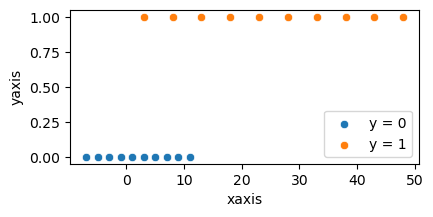

In [441]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4.5, 2))

# Line plot for y = 0
sns.scatterplot(
    x='xaxis',
    y='yaxis',
    data=pd.DataFrame(
        {'xaxis': [i*2-7 for i in range(10)],
         'yaxis': [0 for i in range(10)]}
    ),
    ax=ax,  # Add to the same axis
    label='y = 0'  # Add a label for the legend
)

# Line plot for y = 1
sns.scatterplot(
    x='xaxis',
    y='yaxis',
    data=pd.DataFrame(
        {'xaxis': [i*5+3 for i in range(10)],
         'yaxis': [1 for i in range(10)]}
    ),
    ax=ax,  # Add to the same axis
    label='y = 1'  # Add a label for the legend
)

# Show legend
ax.legend()

# Display the plot
plt.show()


In [389]:
list1 = [i*2-7 for i in list(range(10))]
print(list1)

[-7, -5, -3, -1, 1, 3, 5, 7, 9, 11]


In [385]:
list2 = [i*5+3 for i in list(range(10))]
list2

[3, 8, 13, 18, 23, 28, 33, 38, 43, 48]

In [ ]:
count = 0
duplicates

for i in list1:
    if i in list2 == True:
        count = count + 1
        

In [435]:
import random

random.seed(10)
print(random.random())

0.13436424411240122


In [368]:
pd.DataFrame(
    {'x':list(range(0,3)),
    'y': [0,1,2]}
)

,x,y
0,0,0
1,1,1
2,2,2
